### 1) Preprocessing

In [23]:
import os
import shutil
import shap
import numpy as np
import tensorflow as tf
from keras.utils import image_dataset_from_directory, load_img
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import cv2
from torchvision.transforms.functional import normalize

 1.1) Loading an image dataset from the 'flowers' directory using the image_dataset_from_directory function. It resizes the images to 128x128 pixels and groups them into batches of 32 images each for easier processing.

In [24]:
data = image_dataset_from_directory(
    'flowers',
    image_size=(128, 128),
    batch_size=32 
)

Found 1517 files belonging to 2 classes.


1.2) Labeling the images into arrays and appends them to the respective listsand normalizing the data, and since the pixel values of the images are normalized by dividing by 255.0, scaling the values to the range [0, 1].

In [25]:
images, labels = [], []
for image, label in data:
    images.append(image.numpy())
    labels.append(label.numpy())
images, labels = np.concatenate(images), np.concatenate(labels)
images /= 255.0

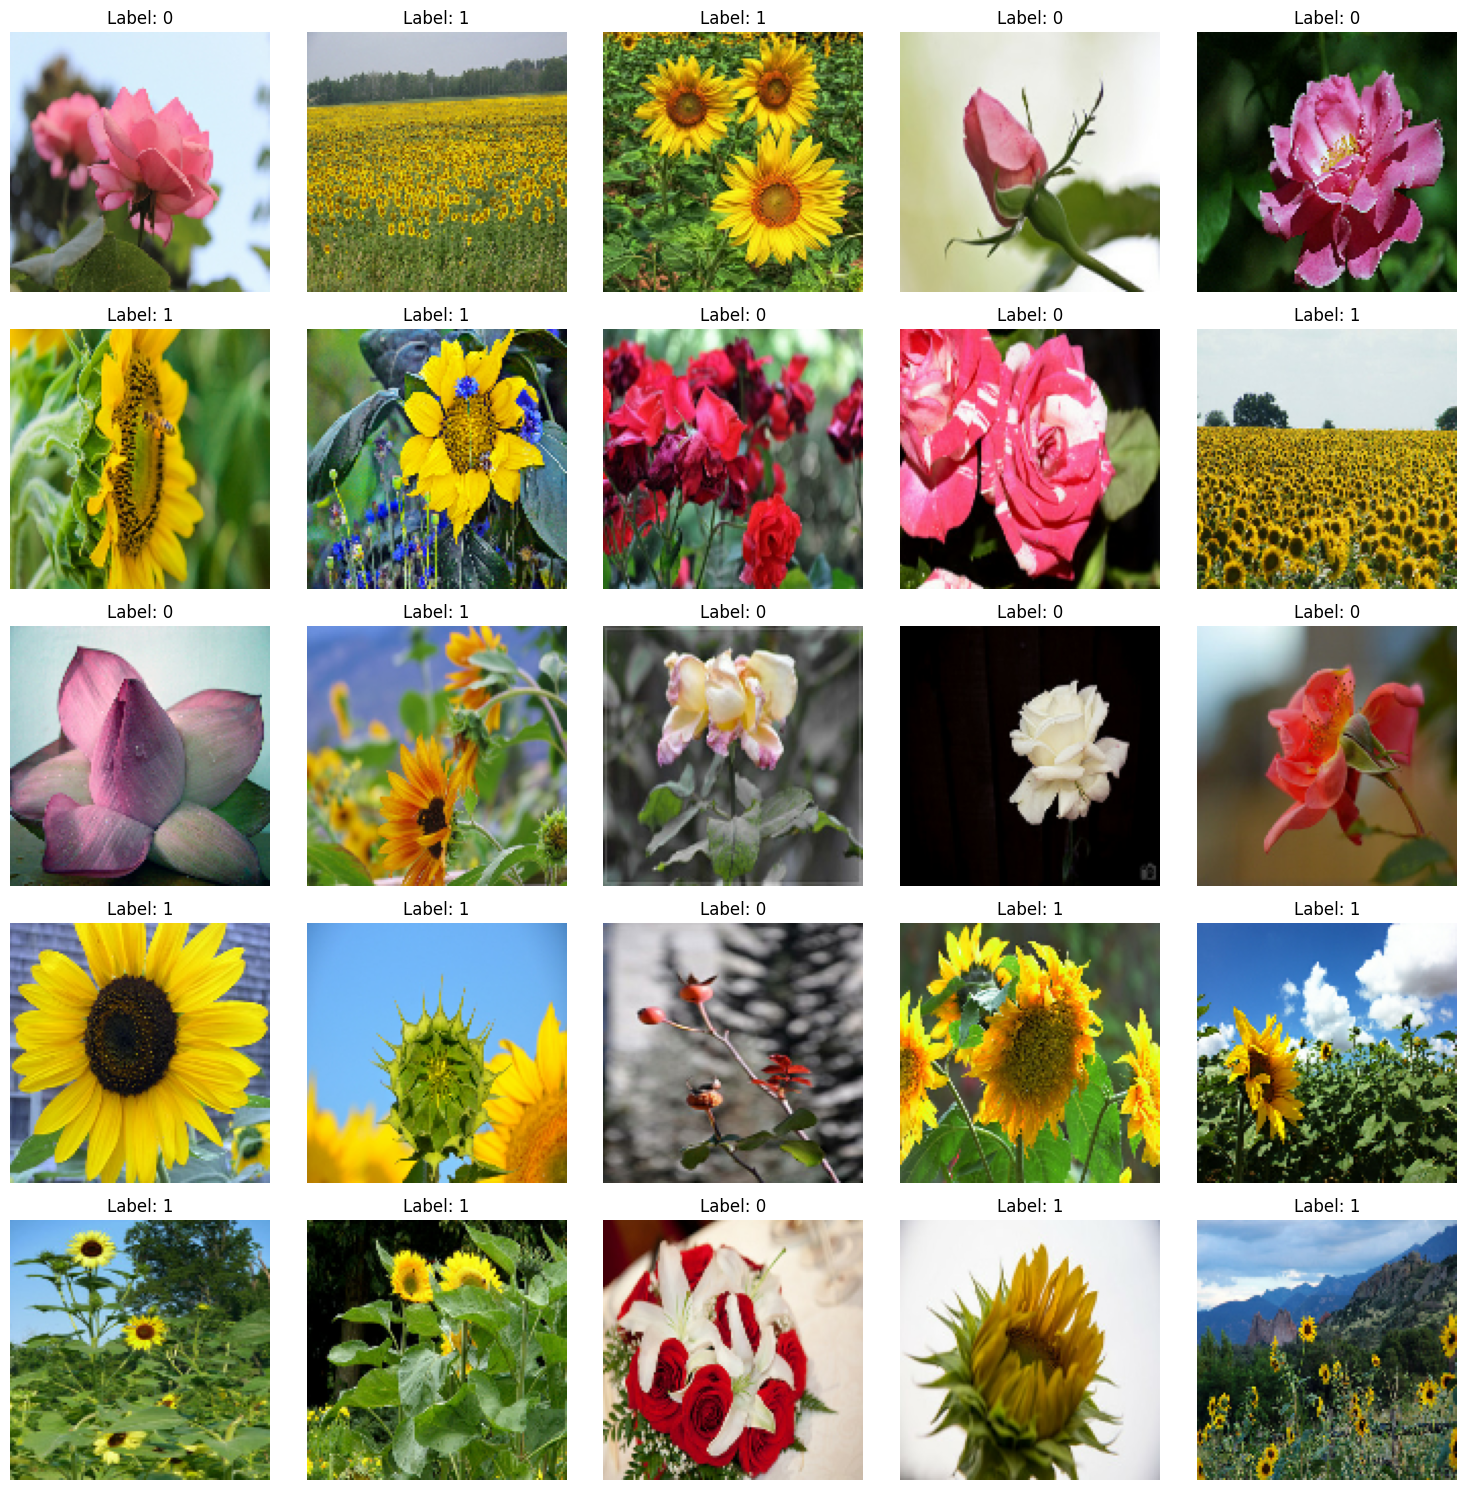

In [26]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(25):
    axes[i].imshow(images[i])
    axes[i].axis('off') 
    axes[i].set_title(f"Label: {labels[i]}")

plt.tight_layout()

### 2) Buidling the model

2.1) Concatenating image and label arrays into training and testing sets using the train_test_split function. 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, shuffle=True, random_state=11, stratify=labels)

2.2) Training a convolutional neural network (CNN) for image classification.

**Model Architecture:**
- <u>Input Layer</u>: The model takes input images of shape (128, 128, 3), where 3 represents the RGB color channels.
- <u>Convolutional Layers:</u>
Conv2D layers apply convolution operations, using 32 filters in the first layer and 16 in the second, with a kernel size of 3x3 and ReLU activation.
MaxPooling2D layers downsample the feature maps by a factor of 2.
- <u>Flatten Layer:</u> The output from the convolutional layers is flattened into a 1D vector.
- Dense Layer: A fully connected layer with 3 output units (for 3 classes).
- <u>Softmax Activation:</u>The output layer uses softmax to produce class probabilities.

The model is compiled with the Adam optimizer, and converts the labels to one-hot encoded format for multi-class classification.

The training process uses a batch size of 32, runs for 10 epochs, and uses 15% of the training data for validation.

In [29]:
inputs = Input(shape=(128, 128, 3), name="Input")
x = Conv2D(32, 3, activation="relu", padding='same', name='Conv1')(inputs)
x = MaxPooling2D(2, name='Pool1')(x)
x = Conv2D(16, 3, activation="relu", padding='same', name='Conv2')(x)
x = MaxPooling2D(2, name='Pool2')(x)
x = Flatten(name='Vectorize')(x)
x = Dense(3, name='FC')(x)
outputs = Activation("softmax", name='Softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()

hist = model.fit(
    X_train,
    to_categorical(y_train, 3),
    batch_size=32,
    epochs=10,
    validation_split=0.15,
    shuffle='on'
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Vectorize (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC (Dense)                      │ (None, 3)              │        49,155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Activation)            │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,675 (213.57 KB)

 Trainable params: 54,675 (213.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - acc: 0.6467 - loss: 0.6516 - val_acc: 0.7895 - val_loss: 0.5214
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - acc: 0.8634 - loss: 0.3543 - val_acc: 0.8713 - val_loss: 0.2918
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - acc: 0.9091 - loss: 0.2315 - val_acc: 0.8772 - val_loss: 0.2562
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - acc: 0.9192 - loss: 0.2064 - val_acc: 0.9006 - val_loss: 0.2368
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - acc: 0.9358 - loss: 0.1771 - val_acc: 0.9123 - val_loss: 0.2243
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - acc: 0.9319 - loss: 0.1831 - val_acc: 0.8538 - val_loss: 0.3226
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - acc: 0.9491 - loss: 0.1407 - val_acc: 0.8889 - val_loss: 0.2488
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - acc: 0.9431 - loss: 0.1691 - val_acc: 0.9006 - val_loss: 0.2296
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - acc: 0.9775

2.3) Evaluating the performance of the trained CNN model on the test

In [7]:
y_hat=model.predict(X_test)
print('Acc=',np.sum(y_hat.argmax(1)==y_test)/y_test.shape[0])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Acc= 0.9289473684210526


### 3) Shap

3.1)  SHAP (SHapley Additive exPlanations) to explain the model's predictions for a specific test image from the dataset. 

- Taking an input x, makes a copy of it, and passes it to the trained model to get predictions.
- Creating a SHAP masker that will generate blurred versions of the input images.

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.39s/it]               


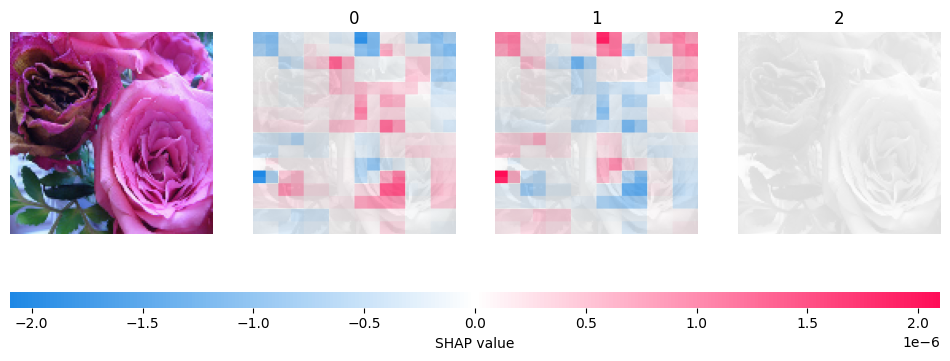

In [33]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(128,128)", X_test[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(3)))
ind=[311]
shap_values_ = explainer( X_test[ind], max_evals=5000, batch_size=50 )     
shap.image_plot(shap_values_,labels=[0,1,2])